In [1]:
import pickle
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys, os
sys.path.append(os.path.abspath("/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH"))
from rerech import utils as ut

# 1) load the pickle of all your rv/return data
raw = ut.load_rv('/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/data/rv.pkl')

# 2) build the dict structure you’ve been using elsewhere
data_dict = ut.build_data_dict(raw)

# 3) pick one of your tickers (e.g. SPX) and take its test-period returns
r = data_dict['SPX']['test']['y_test']

/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH/rerech/utils.py:50: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['rv5'][df['rv5']<=0] = df['rv5'][df['rv5']>0].min()
/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH/re

In [3]:
# Fit normal
μ_norm, σ_norm = norm.fit(r)

# Fit Student-t (df, loc, scale)
df_t, μ_t, σ_t = t.fit(r)


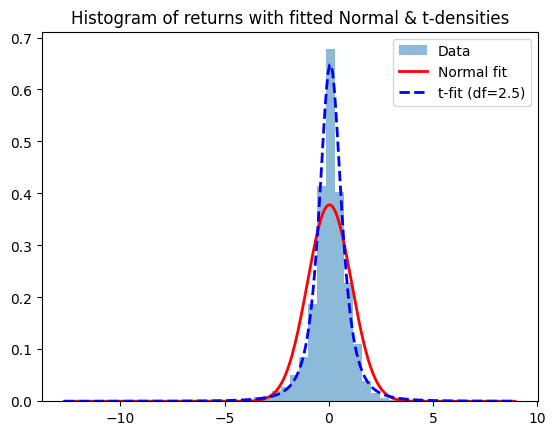

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(r, bins=50, density=True, alpha=0.5, label='Data')

x = np.linspace(r.min(), r.max(), 300)
plt.plot(x, norm.pdf(x, μ_norm, σ_norm),  'r-', lw=2, label='Normal fit')
plt.plot(x, t.pdf(x, df_t, loc=μ_t, scale=σ_t), 'b--', lw=2,
         label=f"t‑fit (df={df_t:.1f})")

plt.legend()
plt.title("Histogram of returns with fitted Normal & t‑densities")
plt.show()


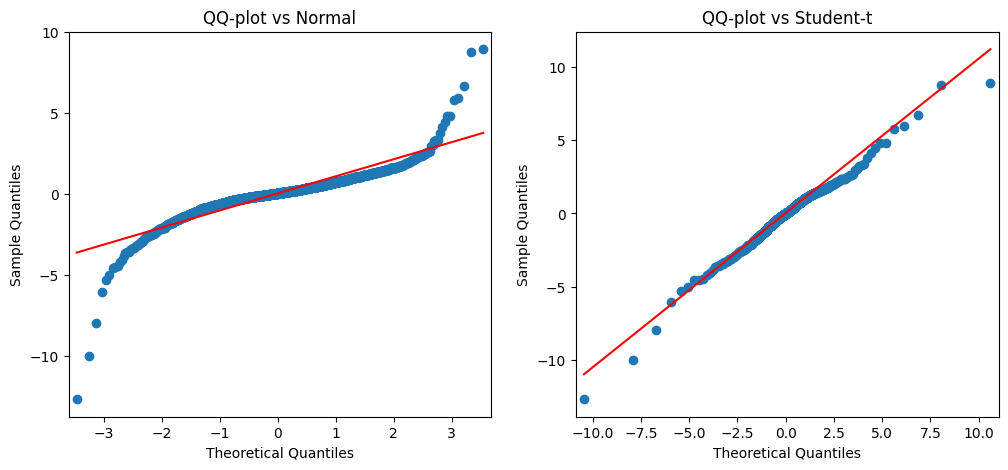

In [5]:
import statsmodels.api as sm

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sm.qqplot(r, dist=norm, loc=μ_norm, scale=σ_norm, line='s', ax=axs[0])
axs[0].set_title("QQ‐plot vs Normal")

sm.qqplot(r, dist=t, distargs=(df_t,), loc=μ_t, scale=σ_t, line='s', ax=axs[1])
axs[1].set_title("QQ‐plot vs Student‑t")
plt.show()


In [6]:
ll_norm = np.sum(norm.logpdf(r, μ_norm, σ_norm))
ll_t    = np.sum(   t.logpdf(r, df_t, loc=μ_t, scale=σ_t))

k_norm = 2          # parameters: (μ, σ)
k_t    = 3          # parameters: (df, loc, scale)

AIC_norm = 2*k_norm - 2*ll_norm
AIC_t    = 2*k_t    - 2*ll_t

print(f"Normal  LL = {ll_norm:.1f},  AIC = {AIC_norm:.1f}")
print(f"Student‑t LL = {ll_t:.1f},  AIC = {AIC_t:.1f}")


Normal  LL = -3325.9,  AIC = 6655.7
Student‑t LL = -2847.8,  AIC = 5701.5


In [2]:
import sys, os
sys.path.append(os.path.abspath("/Users/ananyaparikh/Documents/Coding/DeepRGARCH"))
import pandas as pd
import pickle
import numpy as np
from collections import defaultdict
from rerech import utils as ut
import model_patch 
from rerech import model as mdl, utils as ut, smc

def safe_sigmoid(x):
    """Numerically stable sigmoid function"""
    # Clip extreme values to prevent overflow
    x_safe = np.clip(x, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-x_safe))

# Monkey patch the sigmoid function
ut.sigmoid = safe_sigmoid

# Load data
data_dict = ut.build_data_dict(ut.load_rv(filepath='/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/data/rv.pkl'))
tickers = list(data_dict.keys())
model_dict = defaultdict(lambda: {})

n = 10

/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH/rerech/utils.py:50: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['rv5'][df['rv5']<=0] = df['rv5'][df['rv5']>0].min()
/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH/re

In [3]:
for ticker in tickers:
    data = data_dict[ticker]['train']
    y_train, y_test, rv_train, rv_test = data['y_train'], data['y_test'], data['rv_train'], data['rv_test']
    
    # Train the t-distribution version
    realrech_tdist = mdl.RealRECH_2LSTM_tdist(prior=ut.realrech_2lstm_tdist_prior(), data=[y_train, rv_train])
    
    # Make sure to run this model first before creating the SMCD version
    realrech_tdist.run()
    
    # Only create the SMCD version after running the first model
    model_dict[ticker]['realrech_tdist'] = mdl.RealRECHD_2LSTM_tdist(pre=realrech_tdist, data=[y_train, y_test, rv_train, rv_test])
    
    # And then run the SMCD model
    model_dict[ticker]['realrech_tdist'].run()
    
    # Save model
    with open('checkpoint/{}_{}_{}.pkl'.format(ticker, 'realrech_tdist', n), 'wb') as f:
        pickle.dump(model_dict[ticker]['realrech_tdist'], f)

t=0, accept_rate=0.00, accept_rate2=0.00, epn=0.000
t=1, accept_rate=0.38, accept_rate2=0.90, epn=0.000
t=2, accept_rate=0.34, accept_rate2=0.90, epn=0.000
t=3, accept_rate=0.47, accept_rate2=1.00, epn=0.000
t=4, accept_rate=0.61, accept_rate2=1.00, epn=0.000
t=5, accept_rate=0.68, accept_rate2=1.00, epn=0.000
t=6, accept_rate=0.67, accept_rate2=1.00, epn=0.000
t=7, accept_rate=0.68, accept_rate2=1.00, epn=0.000
t=8, accept_rate=0.74, accept_rate2=1.00, epn=0.000
t=9, accept_rate=0.72, accept_rate2=1.00, epn=0.000
t=10, accept_rate=0.62, accept_rate2=1.00, epn=0.000
t=11, accept_rate=0.50, accept_rate2=1.00, epn=0.000
t=12, accept_rate=0.52, accept_rate2=1.00, epn=0.000
t=13, accept_rate=0.40, accept_rate2=1.00, epn=0.000
t=14, accept_rate=0.39, accept_rate2=1.00, epn=0.001
t=15, accept_rate=0.69, accept_rate2=1.00, epn=0.001
t=16, accept_rate=0.67, accept_rate2=1.00, epn=0.001
t=17, accept_rate=0.61, accept_rate2=1.00, epn=0.001
t=18, accept_rate=0.73, accept_rate2=1.00, epn=0.001
t=1

In [6]:
for ticker in tickers:
    try:
        data = data_dict[ticker]['train']
        y_train, y_test, rv_train, rv_test = data['y_train'], data['y_test'], data['rv_train'], data['rv_test']
        
        # Train the original model with additional safeguards
        print(f"Training RealRECH_2LSTM for {ticker}...")
        realrech_2lstm = mdl.RealRECH_2LSTM(prior=ut.realrech_2lstm_prior, data=[y_train, rv_train])
        
        # Modify the model's loglik method to ensure variance is positive
        original_loglik = realrech_2lstm.loglik
        def safe_loglik(theta, get_v=False):
            # Call the original method
            result = original_loglik(theta, get_v)
            # Ensure variance is positive
            if np.any(np.isnan(result)) or np.any(np.isinf(result)):
                # Return a very negative loglik to discourage these parameters
                return np.ones(theta.shape[0]) * -1e10
            return result
        
        realrech_2lstm.loglik = safe_loglik
        realrech_2lstm.run()
        
        # Similar approach for dynamic model
        model_dict[ticker]['realrech_2lstm'] = mdl.RealRECHD_2LSTM(pre=realrech_2lstm, data=[y_train, y_test, rv_train, rv_test])
        model_dict[ticker]['realrech_2lstm'].run()
        
        # Train the t-distribution version with similar safeguards
        print(f"Training RealRECH_2LSTM_tdist for {ticker}...")
        realrech_tdist = mdl.RealRECH_2LSTM_tdist(prior=ut.realrech_2lstm_tdist_prior, data=[y_train, rv_train])
        
        # Similar approach for t-distribution model
        original_loglik_t = realrech_tdist.loglik
        def safe_loglik_t(theta, get_v=False):
            # Call the original method
            result = original_loglik_t(theta, get_v)
            # Ensure valid result
            if np.any(np.isnan(result)) or np.any(np.isinf(result)):
                return np.ones(theta.shape[0]) * -1e10
            return result
        
        realrech_tdist.loglik = safe_loglik_t
        realrech_tdist.run()
        
        model_dict[ticker]['realrech_tdist'] = mdl.RealRECHD_2LSTM_tdist(pre=realrech_tdist, data=[y_train, y_test, rv_train, rv_test])
        model_dict[ticker]['realrech_tdist'].run()
        
        # Save both models
        os.makedirs('checkpoint', exist_ok=True)
        with open(f'checkpoint/{ticker}_realrech_2lstm_{n}.pkl', 'wb') as f:
            pickle.dump(model_dict[ticker]['realrech_2lstm'], f)
        with open(f'checkpoint/{ticker}_realrech_tdist_{n}.pkl', 'wb') as f:
            pickle.dump(model_dict[ticker]['realrech_tdist'], f)
            
        print(f"Successfully trained and saved models for {ticker}")
        
    except Exception as e:
        print(f"Error processing ticker {ticker}: {str(e)}")
        continue

Training RealRECH_2LSTM for AEX...
t=0, accept_rate=0.00, accept_rate2=0.00, epn=0.000
t=1, accept_rate=0.52, accept_rate2=1.00, epn=0.000
t=2, accept_rate=0.65, accept_rate2=1.00, epn=0.000
t=3, accept_rate=0.65, accept_rate2=1.00, epn=0.000
t=4, accept_rate=0.78, accept_rate2=1.00, epn=0.000
t=5, accept_rate=0.80, accept_rate2=1.00, epn=0.000
t=6, accept_rate=0.73, accept_rate2=1.00, epn=0.000
t=7, accept_rate=0.79, accept_rate2=1.00, epn=0.000
t=8, accept_rate=0.73, accept_rate2=1.00, epn=0.000
t=9, accept_rate=0.67, accept_rate2=1.00, epn=0.000
t=10, accept_rate=0.68, accept_rate2=1.00, epn=0.000
t=11, accept_rate=0.67, accept_rate2=1.00, epn=0.001
t=12, accept_rate=0.64, accept_rate2=1.00, epn=0.001
t=13, accept_rate=0.66, accept_rate2=1.00, epn=0.001
t=14, accept_rate=0.62, accept_rate2=1.00, epn=0.001
t=15, accept_rate=0.70, accept_rate2=1.00, epn=0.002
t=16, accept_rate=0.65, accept_rate2=1.00, epn=0.003
t=17, accept_rate=0.59, accept_rate2=1.00, epn=0.003
t=18, accept_rate=0.5

KeyboardInterrupt: 